Attention Mechanism
==============================

## Download Untility Files for Plotting and Data Generation

Download these utility functions first and place them in the same directory as this notebook. 

In [1]:
from IPython.display import FileLink, FileLinks

In [2]:
FileLink('plots.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\attention\plots.py

In [6]:
FileLink('plots_seq2seq.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\attention\plots_seq2seq.py

In [3]:
FileLink('util.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\attention\util.py

In [4]:
FileLink('replay.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\attention\replay.py

## Imports

In [56]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from util import StepByStep
from plots import *
from plots_seq2seq import *

## Data Generation

Same method as before for generating noisy squares. 

In [22]:
def generate_sequences(n=128, variable_len=False, seed=13):
    basic_corners = np.array([[-1, -1], [-1, 1], [1, 1], [1, -1]])
    np.random.seed(seed)
    bases = np.random.randint(4, size=n)
    if variable_len:
        lengths = np.random.randint(3, size=n) + 2
    else:
        lengths = [4] * n
    directions = np.random.randint(2, size=n)
    points = [basic_corners[[(b + i) % 4 for i in range(4)]][slice(None, None, d*2-1)][:l] + np.random.randn(l, 2) * 0.1 for b, d, l in zip(bases, directions, lengths)]
    return points, directions

### Plain Encoder-Decoder

We use exactly the same encoder-decoder from last lab's sequence to sequence notebook.

In [23]:
class Encoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.hidden = None
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)
                
    def forward(self, X):        
        rnn_out, self.hidden = self.basic_rnn(X)
        
        return rnn_out # N, L, F

In [24]:
class Decoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.hidden = None
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True) 
        self.regression = nn.Linear(self.hidden_dim, self.n_features)
        
    def init_hidden(self, hidden_seq):
        # We only need the final hidden state
        hidden_final = hidden_seq[:, -1:] # N, 1, H
        # But we need to make it sequence-first
        self.hidden = hidden_final.permute(1, 0, 2) # 1, N, H                      
        
    def forward(self, X):
        # X is N, 1, F
        batch_first_output, self.hidden = self.basic_rnn(X, self.hidden) 
        
        last_output = batch_first_output[:, -1:]
        out = self.regression(last_output)
        
        # N, 1, F
        return out.view(-1, 1, self.n_features)               

In [50]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len, teacher_forcing_prob=0.5):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.teacher_forcing_prob = teacher_forcing_prob
        self.outputs = None
        
    def init_outputs(self, batch_size):
        device = next(self.parameters()).device
        # N, L (target), F
        self.outputs = torch.zeros(batch_size, 
                              self.target_len, 
                              self.encoder.n_features).to(device)
    
    def store_output(self, i, out):
        # Stores the output
        self.outputs[:, i:i+1, :] = out
        
    def forward(self, X):               
        # splits the data in source and target sequences
        # the target seq will be empty in testing mode
        # N, L, F
        source_seq = X[:, :self.input_len, :]
        target_seq = X[:, self.input_len:, :]
        self.init_outputs(X.shape[0])        
        
        # Encoder expected N, L, F
        hidden_seq = self.encoder(source_seq)
        # Output is N, L, H
        self.decoder.init_hidden(hidden_seq)
        
        # The last input of the encoder is also
        # the first input of the decoder
        dec_inputs = source_seq[:, -1:, :]
        
        # Generates as many outputs as the target length
        for i in range(self.target_len):
            # Output of decoder is N, 1, F
            out = self.decoder(dec_inputs)
            self.store_output(i, out)
            
            prob = self.teacher_forcing_prob
            # In evaluation/test the target sequence is
            # unknown, so we cannot use teacher forcing
            if not self.training:
                prob = 0
                
            # If it is teacher forcing
            if torch.rand(1) <= prob:
                # Takes the actual element
                dec_inputs = target_seq[:, i:i+1, :]
            else:
                # Otherwise uses the last predicted output
                dec_inputs = out
            
        return self.outputs

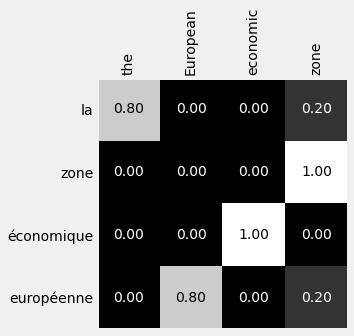

In [25]:
fig = figure9()

## "Values"

$$
context\ vector = \underbrace{\alpha_0 * h_0}_{alignment\ vector_0} + \underbrace{\alpha_1 * h_1}_{alignment\ vector_1} = 0.8 * value_{the} + 0.2 *value_{zone}
$$

### "Keys" and "Queries"

![](images/score_alignment_translate.png)

### Computing the Context Vector

Let's use our own sequence-to-sequence problem, and the "perfect" square as input:

In [26]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]

The source sequence is the input of the encoder, and the hidden states it outputs
are going to be both "values" (V) and "keys" (K):

In [27]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
hidden_seq = encoder(source_seq)

values = hidden_seq # N, L, H
values

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [14]:
keys = hidden_seq # N, L, H
keys

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

The encoder-decoder dynamics stay exactly the same: despite that we are sending the entire sequence of hidden states to the decoder, we still use the encoder's
final hidden state as the decoder's initial hidden state. In this example of using the first two corners to predict the last two, we still use the last element of the source sequence as input to the first step of the decoder:

In [28]:
torch.manual_seed(21)
decoder = Decoder(n_features=2, hidden_dim=2)
decoder.init_hidden(hidden_seq)

inputs = source_seq[:, -1:]
out = decoder(inputs)

The first "query" (Q) is the decoder's hidden state (remember, hidden states are
always sequence-first, so we permute it to batch-first):

In [29]:
query = decoder.hidden.permute(1, 0, 2)  # N, 1, H
query

tensor([[[ 0.3913, -0.6853]]], grad_fn=<PermuteBackward>)

Once we have the "keys" and a "query", we can compute attention scores (alphas) using them. This is for illustration only, we will progressively develop the `calc_alphas()` to reflect the true processing in the digram.

:::{note}
The alphas here do not make use of the values of keys and query, they are simply ones averaged by the sequence length.  
:::

In [30]:
def calc_alphas(ks, q):
    N, L, H = ks.size()
    alphas = torch.ones(N, 1, L).float() * 1/L
    return alphas

alphas = calc_alphas(keys, query)
alphas

tensor([[[0.5000, 0.5000]]])

We had to make sure alphas had the right shape (N, 1, L) so that, when multiplied
by the "values" with shape (N, L, H), it will result in a weighted sum of the
alignment vectors with shape (N, 1, H). We can use batch matrix multiplication
(torch.bmm) for that:

$$(\textcolor{green}{N}, 1, \textcolor{red}{L}) \times (\textcolor{green}{N}, \textcolor{red}{L}, H) = (N, 1, H)$$

We can simply ignore the first dimension and PyTorch will go over all the elements in the mini-batch for us.

:::{warning} Why are we spending so much time on shapes and matrix multiplication?

Although it seems a fairly basic topic, getting the shapes and dimensions right is of utmost importance for the correct implementation of an algorithm or technique.
Worst case is when using the wrong dimensions in an operation, PyTorch *may not raise an explicit error*, causing the almost undetectable Logical Error. This will ultimately damage the model's ability to learn.
:::

In [31]:
# N, 1, L x N, L, H -> 1, L x L, H -> 1, H
context_vector = torch.bmm(alphas, values)
context_vector

tensor([[[ 0.1968, -0.2809]]], grad_fn=<BmmBackward0>)

Once the context vector is ready, we can concatenate it to the "query" (the
decoder's hidden state) and use it as the input for the linear layer that actually
generates the predicted coordinates:

In [32]:
concatenated = torch.cat([context_vector, query], axis=-1)
concatenated

tensor([[[ 0.1968, -0.2809,  0.3913, -0.6853]]], grad_fn=<CatBackward>)

![](images/encdec_attn.png)

### Scoring Method

$$
cos\ \theta = \frac{\sum_i{q_ik_i}}{\sqrt{\sum_j{q_j^2}}\sqrt{\sum_j{k_j^2}}}
$$

$$
cos\ \theta \sqrt{\sum_j{q_j^2}}\sqrt{\sum_j{k_j^2}}= \sum_i{q_ik_i}
$$

$$
cos \theta\ ||Q||\ ||K|| = Q \cdot K
$$

In [33]:
# N, 1, H x N, H, L -> N, 1, L
products = torch.bmm(query, keys.permute(0, 2, 1))
products

tensor([[[0.0569, 0.4821]]], grad_fn=<BmmBackward0>)

### Attention Scores

In [34]:
alphas = F.softmax(products, dim=-1)
alphas

tensor([[[0.3953, 0.6047]]], grad_fn=<SoftmaxBackward>)

In [35]:
def calc_alphas(ks, q):
    # N, 1, H x N, H, L -> N, 1, L
    products = torch.bmm(q, ks.permute(0, 2, 1))
    alphas = F.softmax(products, dim=-1)    
    return alphas

### Visualizing the Context Vector

In [36]:
q = torch.tensor([.55, .95]).view(1, 1, 2) # N, 1, H
k = torch.tensor([[.65, .2], 
                  [.85, -.4], 
                  [-.95, -.75]]).view(1, 3, 2) # N, L, H

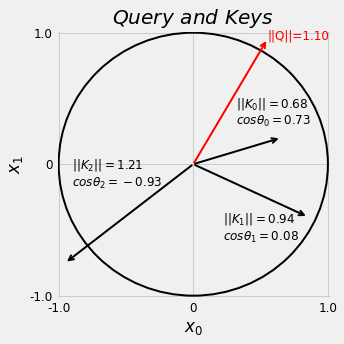

In [37]:
fig = query_and_keys(q.squeeze(), k.view(3, 2))

$$
\Large
\begin{align*}
Q \cdot K_0 = cos \theta_0\ ||Q||\ ||K_0|| =& &0.73 &*& 1.10 &*& 0.68 =& &0.54
\\
Q \cdot K_1 = cos \theta_1\ ||Q||\ ||K_1|| =& &0.08 &*& 1.10 &*& 0.94 =& &0.08
\\
Q \cdot K_2 = cos \theta_2\ ||Q||\ ||K_2|| =& -&0.93 &*& 1.10 &*& 1.21 =& -&1.23
\end{align*}
$$

In [ ]:
# N, 1, H x N, H, L -> N, 1, L
prod = torch.bmm(q, k.permute(0, 2, 1))
prod

tensor([[[ 0.5475,  0.0875, -1.2350]]])

In [ ]:
scores = F.softmax(prod, dim=-1)
scores

tensor([[[0.5557, 0.3508, 0.0935]]])

In [ ]:
v = k
context = torch.bmm(scores, v)
context

tensor([[[ 0.5706, -0.0993]]])

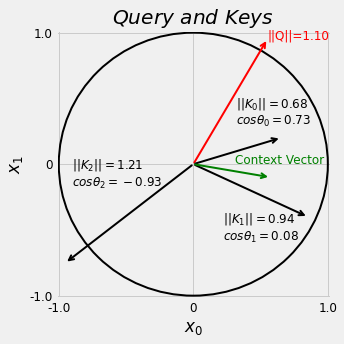

In [ ]:
fig = query_and_keys(q.squeeze(), k.view(3, 2), context)

### Scaled Dot Product

In [ ]:
n_dims = 10
dummy_qs = torch.randn(10000, 1, n_dims)
dummy_ks = torch.randn(10000, 1, n_dims).permute(0, 2, 1)
torch.bmm(dummy_qs, dummy_ks).squeeze().var()

tensor(9.7670)

$$
\Large
Var(Q \cdot K) = d_q = d_k
\\
\Large
\sigma(Q \cdot K) = \sqrt{d_q} = \sqrt{d_k}
$$

In [ ]:
dummy_product = torch.tensor([4.0, 1.0])
F.softmax(dummy_product, dim=-1), F.softmax(100*dummy_product, dim=-1)

(tensor([0.9526, 0.0474]), tensor([1., 0.]))

$$
\Large
scaled\ dot\ product = \frac{Q \cdot K}{\sqrt{d_k}}
$$

In [ ]:
scaled_products = products / np.sqrt(2)
scaled_products

tensor([[[0.0403, 0.3409]]], grad_fn=<DivBackward0>)

In [ ]:
alphas = F.softmax(scaled_products, dim=-1)
alphas

tensor([[[0.4254, 0.5746]]], grad_fn=<SoftmaxBackward>)

![](images/aiayn_dot.png)

In [38]:
def calc_alphas(ks, q):
    dims = q.size(-1)
    # N, 1, H x N, H, L -> N, 1, L
    products = torch.bmm(q, ks.permute(0, 2, 1))
    scaled_products = products / np.sqrt(dims)
    alphas = F.softmax(scaled_products, dim=-1)    
    return alphas

In [39]:
alphas = calc_alphas(keys, query)
# N, 1, L x N, L, H -> 1, L x L, H -> 1, H
context_vector = torch.bmm(alphas, values)
context_vector

tensor([[[ 0.2138, -0.3175]]], grad_fn=<BmmBackward0>)

### Attention Mechanism

![](images/attention.png)

In [41]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, input_dim=None, proj_values=False):
        super().__init__()
        self.d_k = hidden_dim
        self.input_dim = hidden_dim if input_dim is None else input_dim
        self.proj_values = proj_values
        # Affine transformations for Q, K, and V
        self.linear_query = nn.Linear(self.input_dim, hidden_dim)
        self.linear_key = nn.Linear(self.input_dim, hidden_dim)
        self.linear_value = nn.Linear(self.input_dim, hidden_dim)
        self.alphas = None
                
    def init_keys(self, keys):
        self.keys = keys
        self.proj_keys = self.linear_key(self.keys)
        self.values = self.linear_value(self.keys) \
                      if self.proj_values else self.keys
                
    def score_function(self, query):
        proj_query = self.linear_query(query)
        # scaled dot product
        # N, 1, H x N, H, L -> N, 1, L
        dot_products = torch.bmm(proj_query, self.proj_keys.permute(0, 2, 1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores
            
    def forward(self, query, mask=None):
        # Query is batch-first N, 1, H
        scores = self.score_function(query) # N, 1, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, 1, L
        self.alphas = alphas.detach()
        
        # N, 1, L x N, L, H -> N, 1, H
        context = torch.bmm(alphas, self.values)
        return context

### Source Mask

In [42]:
source_seq = torch.tensor([[[-1., 1.], [0., 0.]]])
# pretend there's an encoder here...
keys = torch.tensor([[[-.38, .44], [.85, -.05]]])
query = torch.tensor([[[-1., 1.]]])

In [43]:
source_mask = (source_seq != 0).all(axis=2).unsqueeze(1)
source_mask # N, 1, L

tensor([[[ True, False]]])

In [44]:
torch.manual_seed(11)
attnh = Attention(2)
attnh.init_keys(keys)

context = attnh(query, mask=source_mask)
attnh.alphas

tensor([[[1., 0.]]])

### Decoder

In [45]:
class DecoderAttn(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.hidden = None
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True) 
        self.attn = Attention(self.hidden_dim)
        self.regression = nn.Linear(2 * self.hidden_dim, self.n_features)
        
    def init_hidden(self, hidden_seq):
        # the output of the encoder is N, L, H
        # and init_keys expects batch-first as well
        self.attn.init_keys(hidden_seq)
        hidden_final = hidden_seq[:, -1:]
        self.hidden = hidden_final.permute(1, 0, 2)   # L, N, H                      
        
    def forward(self, X, mask=None):
        # X is N, 1, F
        batch_first_output, self.hidden = self.basic_rnn(X, self.hidden) 
        
        query = batch_first_output[:, -1:]
        # Attention 
        context = self.attn(query, mask=mask)
        concatenated = torch.cat([context, query], axis=-1)
        out = self.regression(concatenated)
        
        # N, 1, F
        return out.view(-1, 1, self.n_features)

In [46]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]

In [48]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder_attn = DecoderAttn(n_features=2, hidden_dim=2)

# Generates hidden states (keys and values)
hidden_seq = encoder(source_seq)
decoder_attn.init_hidden(hidden_seq)

# Target sequence generation
inputs = source_seq[:, -1:]
target_len = 2
for i in range(target_len):
    out = decoder_attn(inputs)
    print(f'Output: {out}')    
    inputs = out

Output: tensor([[[-0.3555, -0.1220]]], grad_fn=<ViewBackward>)
Output: tensor([[[-0.2641, -0.2521]]], grad_fn=<ViewBackward>)


### Encoder + Decoder + Attention

![](images/encdec_attn.png)

In [51]:
encdec = EncoderDecoder(encoder, decoder_attn, input_len=2, target_len=2, teacher_forcing_prob=0.0)
encdec(full_seq)

tensor([[[-0.3555, -0.1220],
         [-0.2641, -0.2521]]], grad_fn=<CopySlices>)

In [53]:
class EncoderDecoderAttn(EncoderDecoder):
    def __init__(self, encoder, decoder, input_len, target_len, teacher_forcing_prob=0.5):
        super().__init__(encoder, decoder, input_len, target_len, teacher_forcing_prob)
        self.alphas = None
        
    def init_outputs(self, batch_size):
        device = next(self.parameters()).device
        # N, L (target), F
        self.outputs = torch.zeros(batch_size, 
                              self.target_len, 
                              self.encoder.n_features).to(device)
        # N, L (target), L (source)
        self.alphas = torch.zeros(batch_size, 
                                  self.target_len, 
                                  self.input_len).to(device)
        
    def store_output(self, i, out):
        # Stores the output
        self.outputs[:, i:i+1, :] = out
        self.alphas[:, i:i+1, :] = self.decoder.attn.alphas

### Data Preparation

In [58]:
points, directions = generate_sequences()
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]

In [59]:
test_points, test_directions = generate_sequences(seed=19)
full_test = torch.as_tensor(points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]

In [60]:
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)

generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

### Model Configuration & Training

In [62]:
torch.manual_seed(23)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder_attn = DecoderAttn(n_features=2, hidden_dim=2)
model = EncoderDecoderAttn(encoder, decoder_attn, input_len=2, target_len=2, teacher_forcing_prob=0.5)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [63]:
sbs_seq_attn = StepByStep(model, loss, optimizer)
sbs_seq_attn.set_loaders(train_loader, test_loader)
sbs_seq_attn.train(100)

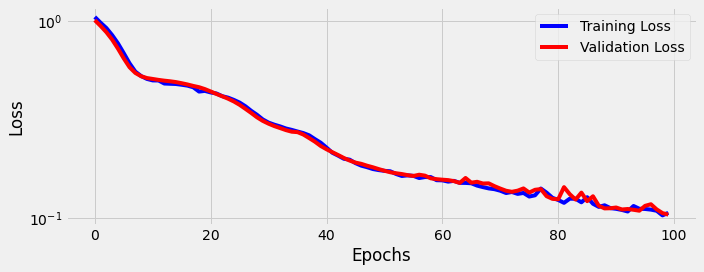

In [64]:
fig = sbs_seq_attn.plot_losses()

### Visualizing Predictions

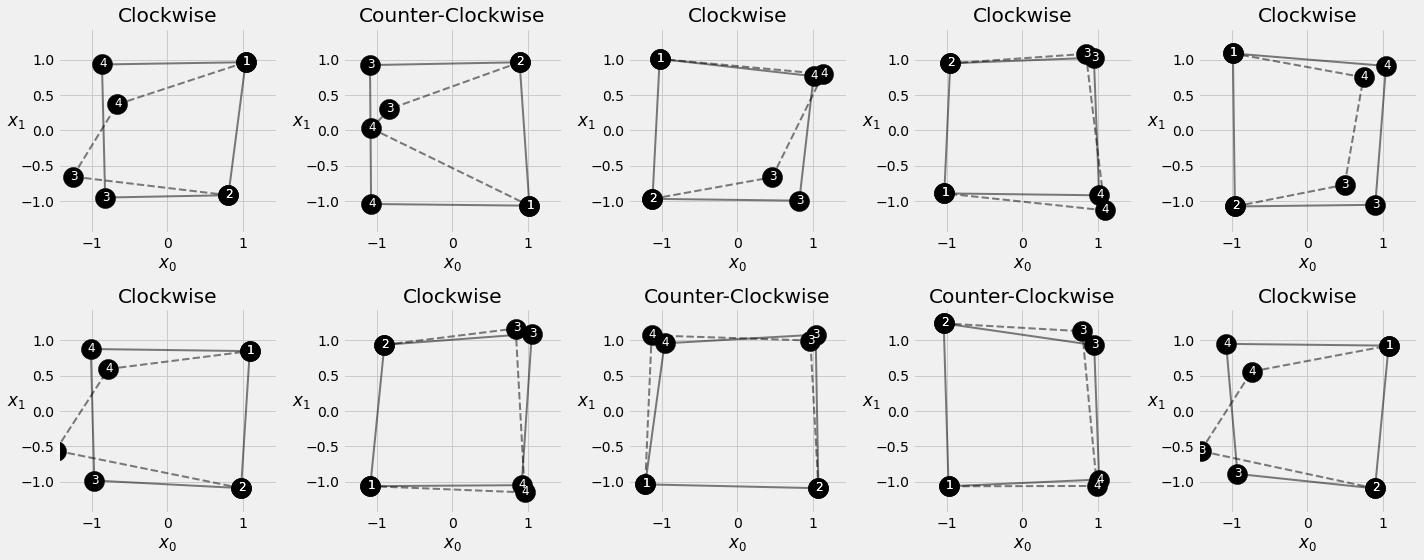

In [65]:
fig = sequence_pred(sbs_seq_attn, full_test, test_directions)

### Visualizing Attention

In [66]:
inputs = full_train[:1, :2]
out = sbs_seq_attn.predict(inputs)
sbs_seq_attn.model.alphas

tensor([[[7.8848e-04, 9.9921e-01],
         [1.0210e-02, 9.8979e-01]]], device='cuda:0')

$$
\Large
\begin{array}{c|cc}
& source\\
target& \color{red}{x_0} & \color{red}{x_1} \\
\hline
 \color{green}{x_2} & \alpha_{\color{green}{2}\color{red}0} & \alpha_{{\color{green}{2}\color{red}1}} \\
 \color{green}{x_3} & \alpha_{\color{green}{3}\color{red}0} & \alpha_{{\color{green}{3}\color{red}1}}
\end{array}
\implies
\Large
\begin{array}{c|cc}
& source\\
target& \color{red}{x_0} & \color{red}{x_1} \\
\hline
 \color{green}{x_2} & 0.0011 & 0.9989\\
 \color{green}{x_3} & 0.0146 & 0.9854
\end{array}
$$

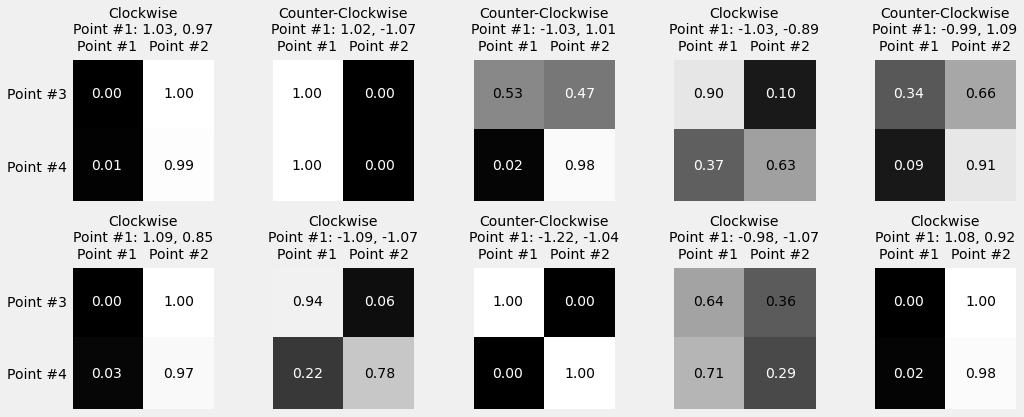

In [67]:
inputs = full_train[:10, :2]
source_labels = ['Point #1', 'Point #2']
target_labels = ['Point #3', 'Point #4']
point_labels = [f'{"Counter-" if not directions[i] else ""}Clockwise\nPoint #1: {inp[0, 0]:.2f}, {inp[0, 1]:.2f}' for i, inp in enumerate(inputs)]
fig = plot_attention(model, inputs, point_labels, source_labels, target_labels)